<a href="https://colab.research.google.com/github/derpen/MachineLearningStuff/blob/main/CatDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=61cb52610a0dd536984c00ece03500d0a7f444ee2fdba16a2886010cc83be13d
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
# Upload kaggle.json to download dataset
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes


In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:05<00:00, 166MB/s]
100% 812M/812M [00:05<00:00, 153MB/s]


In [5]:
!unzip -qo dogs-vs-cats.zip -d dogsvscats
!unzip -qo dogsvscats/test1.zip -d dogsvscats/test && unzip -qo dogsvscats/train.zip -d dogsvscats/train

In [6]:
!ls dogsvscats/train/train | grep cat | wc -l
!ls dogsvscats/train/train | grep dog | wc -l
!ls dogsvscats/test/test1 | wc -l

12500
12500
12500


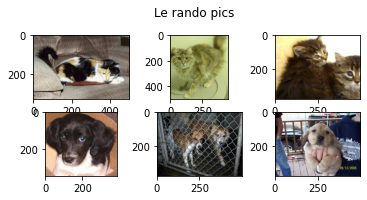

In [7]:
from matplotlib import pyplot
from matplotlib.image import imread
import random

folder = 'dogsvscats/test/test1/'

for i in range(6):
  rand = random.randint(0, 12500)

  pyplot.subplot(3, 3, i + 1)
  
  filename = folder + str(rand) + '.jpg'

  image = imread(filename)
  
  pyplot.imshow(image)

pyplot.suptitle("Le rando pics")
pyplot.show()

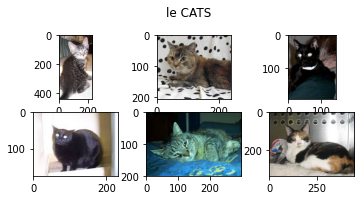

In [8]:
from matplotlib import pyplot
from matplotlib.image import imread
import random

folder = 'dogsvscats/train/train/'

for i in range(6):
  rand = random.randint(0, 12500)
  pyplot.subplot(3, 3, i + 1)
  
  filename = folder + 'cat.' + str(rand) + '.jpg'
  
  image = imread(filename)
  
  pyplot.imshow(image)

pyplot.suptitle("le CATS")
pyplot.show()

In [9]:
import os
from shutil import copyfile

base_dir = 'dataset_dogs_vs_cats'
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

dirs = [base_dir, train_dir, test_dir, test_cats_dir, test_dogs_dir, train_cats_dir, train_dogs_dir]

for dir in dirs:
  os.makedirs(dir, exist_ok=True)

# Split Data
random.seed(1)
# Split 20% to test
val_split = 0.2
src = 'dogsvscats/train/train/'

for files in os.listdir(src):
  src_files = src + files
  if random.random() < val_split:
    if files.startswith('cat'):
      test_cats = test_cats_dir + '/' + files
      copyfile(src_files, test_cats)
    elif files.startswith('dog'):
      test_dogs = test_dogs_dir + '/' + files
      copyfile(src_files, test_dogs)
  else:
    if files.startswith('cat'):
      train_cats = train_cats_dir + '/' + files
      copyfile(src_files, train_cats)
    elif files.startswith('dog'):
      train_dogs = train_dogs_dir + '/' + files
      copyfile(src_files, train_dogs) 

In [10]:
!ls dataset_dogs_vs_cats/test/cats | wc -l
!ls dataset_dogs_vs_cats/test/dogs | wc -l
!ls dataset_dogs_vs_cats/train/cats | wc -l
!ls dataset_dogs_vs_cats/train/dogs | wc -l

2549
2541
9951
9959


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model
 
train_datagen = ImageDataGenerator(
                    # featurewise_center=True,
                    # featurewise_std_normalization=True,
                    rotation_range=45,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    # vertical_flip=True,
                    rescale=1./255
                    ) 
 
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(128, 128),  
        batch_size=32,
        class_mode='categorical')
 
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=(128, 128), 
        batch_size=32,
        class_mode='categorical')

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


In [ ]:
# Restore model if it already exist
model = load_model('model.h5')

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.5),

    # tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax'),
])

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [15]:
# Reduce overfitting

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [16]:
epochs = 50

history = model.fit(
      train_generator,
      steps_per_epoch=623,  #  Train size / Batch size
      epochs=epochs,
      validation_data=test_generator, 
      validation_steps=160,  # Validation size / Batch size
      callbacks = callbacks,
      verbose=2)

Epoch 1/50
623/623 - 173s - loss: 0.6861 - accuracy: 0.5387 - val_loss: 0.6681 - val_accuracy: 0.5902
Epoch 2/50
623/623 - 141s - loss: 0.6605 - accuracy: 0.6002 - val_loss: 0.6169 - val_accuracy: 0.6617
Epoch 3/50
623/623 - 141s - loss: 0.5918 - accuracy: 0.6835 - val_loss: 0.5102 - val_accuracy: 0.7511
Epoch 4/50
623/623 - 143s - loss: 0.5438 - accuracy: 0.7248 - val_loss: 0.4745 - val_accuracy: 0.7735
Epoch 5/50
623/623 - 140s - loss: 0.5051 - accuracy: 0.7544 - val_loss: 0.4811 - val_accuracy: 0.7703
Epoch 6/50
623/623 - 140s - loss: 0.4813 - accuracy: 0.7706 - val_loss: 0.4407 - val_accuracy: 0.7967
Epoch 7/50
623/623 - 140s - loss: 0.4565 - accuracy: 0.7865 - val_loss: 0.3938 - val_accuracy: 0.8246
Epoch 8/50
623/623 - 142s - loss: 0.4304 - accuracy: 0.8015 - val_loss: 0.3501 - val_accuracy: 0.8448
Epoch 9/50
623/623 - 140s - loss: 0.4077 - accuracy: 0.8126 - val_loss: 0.3602 - val_accuracy: 0.8371
Epoch 10/50
623/623 - 138s - loss: 0.3855 - accuracy: 0.8276 - val_loss: 0.3392 - 

Saving test4.jpg to test4.jpg
test4.jpg
[[0. 1.]]
dogs


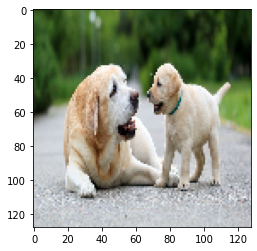

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(128,128))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  if classes[0][0]==1:
    print('cats')
  else:
    print('dogs')

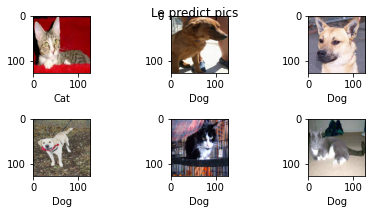

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
from keras.preprocessing import image
import random

folder = 'dogsvscats/test/test1/'

for i in range(6):
  rand = random.randint(0, 12500)

  pyplot.subplot(3, 3, i + 1)

  path = folder + str(rand) + '.jpg'

  testimage = image.load_img(path, target_size=(128,128))
  imgplot = plt.imshow(testimage)
  x = image.img_to_array(testimage)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  if classes[0][0]==1:
    plt.xlabel('Cat')
  else:
    plt.xlabel('Dog')
  
plt.tight_layout()
pyplot.suptitle("Le predict pics")
pyplot.show()

In [22]:
save_model(model, "model.h5")

In [ ]:
# TO DO : LE PREDICT